In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Cross-match and ratio test

- Given a *query* and a *train* image (query = object we want to find, train = where it could be).
- We will look at the two best matches for a descriptor from the query into the train. We will accept a match if it is significantly closer to the first best match than to the second. **Ratio test**.
- Filter out from matches that are good matches between the query and train image and viceversa.

In [2]:
img0 = cv2.imread("./data/img/nemo.jpg",0)
img1 = cv2.imread("./data/img/nemo-sea.jpg",0)

### 1. Create detector, detect keypoints and descriptors in both directions

In [3]:
detector = cv2.ORB_create(100) # at most 100 descriptors
kps0, desc0 = detector.detectAndCompute(img0, None)
kps1, desc1 = detector.detectAndCompute(img1, None)

### 2. Match found descriptors with k-nearest neighbours match

In [4]:
matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING, False)

In [5]:
matches01 = matcher.knnMatch(desc0, desc1, k=2)
matches10 = matcher.knnMatch(desc1, desc0, k=2)

In [6]:
matches01[0][0].distance # Distance between (first descriptor in Nemo, best match found) ==> Lower = better

61.0

In [7]:
matches01[0][1].distance # Distance between (first descriptor in Nemo, second best match found)

86.0

In [8]:
## Logic we want to get:

ratio = matches01[0][0].distance/matches01[0][1].distance
ratio

0.7093023255813954

If the ratio is small than `ratio_thr`, then this means that the best match is significantly better than the second best match.

### 3. Write that logic into a function

In [9]:
def ratio_test(matches, thr):
    # Input: List of matches and threshold
    # Output: List of "good" matches
    good_matches = []
    for m in matches:
        ratio = m[0].distance/m[1].distance # Best match distance / Second best match distance
        if ratio < thr:
            good_matches.append(m[0]) # Keep the best match
    return good_matches

In [10]:
thr = 0.7
good_matches01 = ratio_test(matches01,thr)
good_matches10 = ratio_test(matches10, thr)

In [11]:
len(good_matches10)


9

### 4. Keep only matches in both directions

In [12]:
good_matches10_ = [(m.trainIdx, m.queryIdx) for m in good_matches10] #World -> Nemo
# List of idxs of descriptor on the img0, img1

In [13]:
final_matches = [m for m in good_matches01 if (m.queryIdx, m.trainIdx) in good_matches10_]

In [14]:
len(final_matches)

7

In [16]:
show_img = cv2.drawMatches(
    img0, kps0,
    img1, kps1, 
    final_matches, None
)

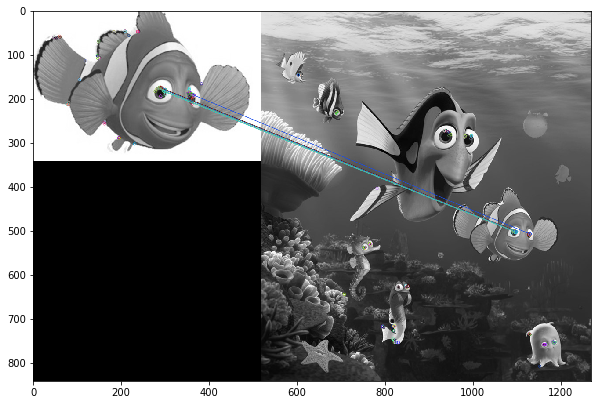

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(show_img[:,:,::-1])

# Model-based filtering using RANSAC

- Discard some not so good matches by filtering those that are not preserved through projective transformation


In [19]:
nemo = cv2.imread("../opencv-np-workshop/data/img/nemo.jpg", 0)
nemo_rotated = cv2.imread("../opencv-np-workshop/data/img/nemo-rotated.jpg",0)

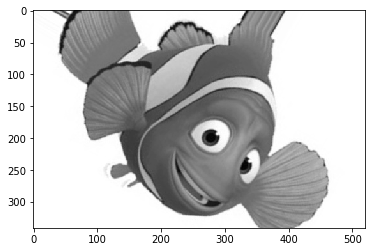

In [20]:
plt.imshow(nemo_rotated, cmap="gray")

### 1. Match keypoints and descriptors

In [59]:
detector = cv2.ORB_create(100)
kps_nemo, desc_nemo = detector.detectAndCompute(nemo, None)
kps_nemo_rot, desc_nemo_rot = detector.detectAndCompute(nemo_rotated, None)

In [60]:
len(kps_nemo)

100

In [61]:
len(kps_nemo_rot)

100

In [62]:
matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING, False)
matches = matcher.match(desc_nemo, desc_nemo_rot)

In [63]:
len(matches)

100

### 2. Find the homography model

In [64]:
# Keep points in Nemo that corresponding to descriptors in the matches list
pts_nemo = [kps_nemo[m.queryIdx].pt for m in matches] # = [point.pt for point in kps_nemo]
pts_nemo_rot = [kps_nemo_rot[m.trainIdx].pt for m in matches]

In [65]:
pts_nemo = np.float32(pts_nemo).reshape(-1,2)
pts_nemo_rot = np.float32(pts_nemo_rot).reshape(-1,2)

In [66]:
# Calculate the homography transformation between pts_nemo and pts_nemo_rot

In [67]:
H, mask = cv2.findHomography(pts_nemo, pts_nemo_rot, cv2.RANSAC, 3.0) #3.0 = parameter for RANSAC

In [68]:
matches_homography = [m for i,m in enumerate(matches) if mask[i]]

In [69]:
len(matches_homography)

68

In [70]:
len(matches)

100

In [72]:
show_img = cv2.drawMatches(
    nemo, kps_nemo,
    nemo_rotated, kps_nemo_rot, 
    matches_homography, 
    None
)

In [73]:
show_img_all = cv2.drawMatches(
    nemo, kps_nemo,
    nemo_rotated, kps_nemo_rot, 
    matches, 
    None
)

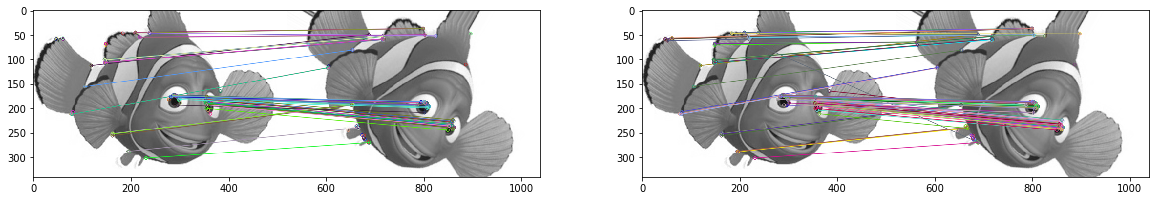

In [76]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(show_img, cmap="gray")
plt.subplot(122)
plt.imshow(show_img_all, cmap="gray")

In [77]:
len(matches_homography)

68

In [83]:
best_match_dist = sorted([m.distance for m in matches_homography])[0] #Distance between matches

In [ ]:
if best_match_dist > 40:
    # no good match, return frame
else:
    # good match, draw rectangle
    
    